In [9]:
import os
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import pandas as pd
import sys
sys.path.append('../scripts')
from data_cleaning import load_data
from feature_engineering import scale_financial_feature
from modeling import train_linear_regression
from evaluation import evaluate_predictions

In [21]:
df = load_data("../data/processed/main_dataset.csv")
df.head()

c:\Users\2023\Desktop\Arshia_project\Gold_Usd_Oil_IRR\notebooks\../scripts\data_cleaning.py:10: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  df["Date"] = pd.to_datetime(df["Date"], errors="ignore")
c:\Users\2023\Desktop\Arshia_project\Gold_Usd_Oil_IRR\notebooks\../scripts\data_cleaning.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date"] = pd.to_datetime(df["Date"], errors="ignore")
c:\Users\2023\Desktop\Arshia_project\Gold_Usd_Oil_IRR\notebooks\../scripts\data_cleaning.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)


,Date,Gold,USD,Oil
0,1403/02/16,32778000,606100,70.79
1,1403/02/17,32894000,602200,71.20
2,1403/02/18,32981000,597200,71.23
3,1403/02/19,33058000,599500,71.27
4,1403/02/20,33113000,634600,71.34


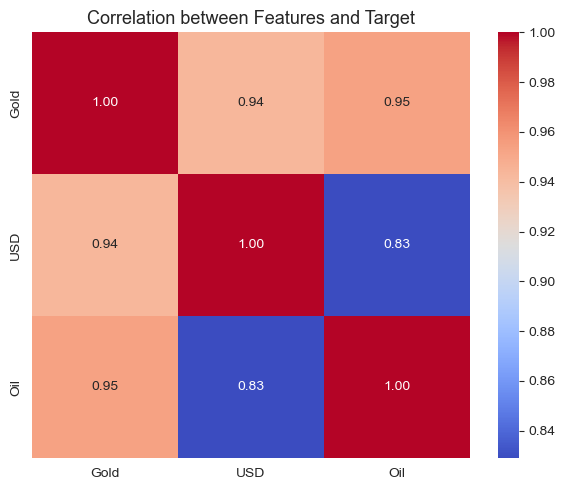

In [23]:
plt.figure(figsize=(6,5))
corr = df[['Gold', 'USD', 'Oil']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation between Features and Target', fontsize=13)
plt.tight_layout()
plt.savefig("../outputs/figures/heatmap.png")
plt.show()

In [4]:
scaled_df, scaler = scale_financial_feature(df)
scaled_df

,Date,Gold,USD,Oil
0,1403/02/16,-1.215415,-0.605913,-1.758115
1,1403/02/17,-1.192585,-0.668340,-1.672629
2,1403/02/18,-1.175516,-0.748968,-1.666393
3,1403/02/19,-1.160446,-0.711796,-1.658083
4,1403/02/20,-1.149703,-0.161555,-1.643552
...,...,...,...,...
204,1403/10/23,1.855464,2.158347,1.843461
205,1403/10/24,1.869668,2.253189,1.859847
206,1403/10/26,1.871624,2.136744,1.897464
207,1403/10/27,1.924476,2.086751,1.921946


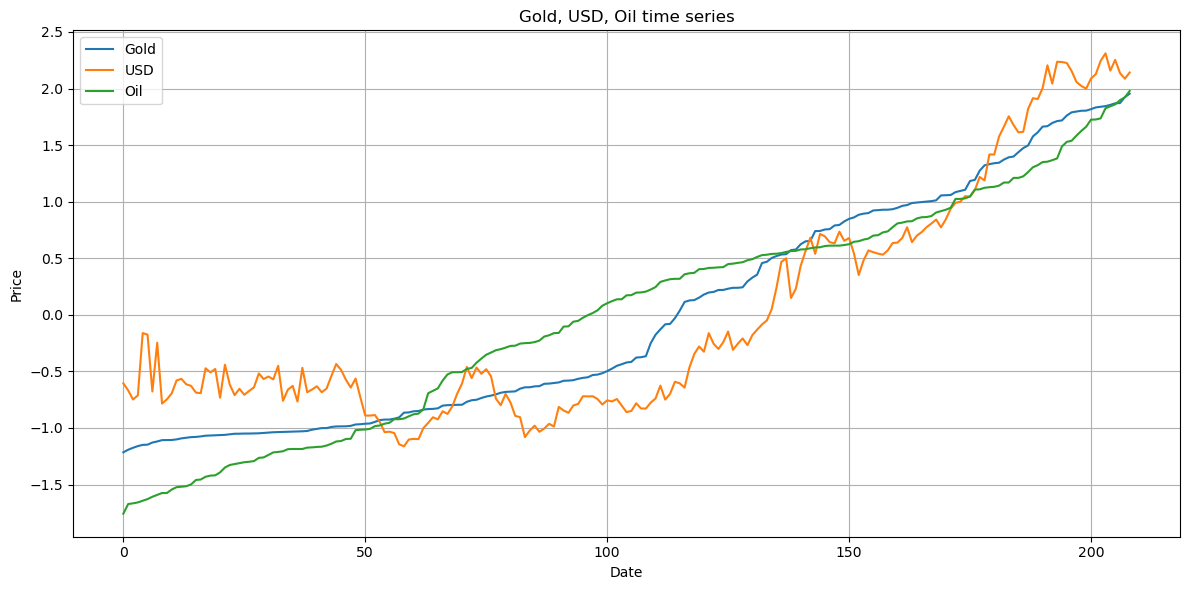

In [5]:
save_path = '../outputs/figures/time_series.png'
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.figure(figsize=(12, 6))

columns = ['Gold', 'USD', 'Oil']
for col in columns:
    plt.plot(scaled_df[col], label=col)
    
plt.legend()
plt.title("Gold, USD, Oil time series")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.tight_layout()
plt.savefig(save_path)
plt.show()

In [6]:
model, metrics, y_test, y_pred = train_linear_regression(scaled_df)

for key, value in metrics.items():
    print(f" {key}: {value}")

 MSE: 0.13239834975047124
 R2: -0.4549933654901237
 Intercept: 0.064624159271163
 Coefficients: {'USD': 0.5888824116053935, 'Oil': 0.5729269973213951}


In [7]:
eval_results, eval_metrics = evaluate_predictions(y_test, y_pred)
for key, value in eval_metrics.items():
    print(f" {key}: {value}")

 MAE: 0.3220727063687509
 RMSE: 0.5675144988180927
 AvgPercentError: 19.914597595139508


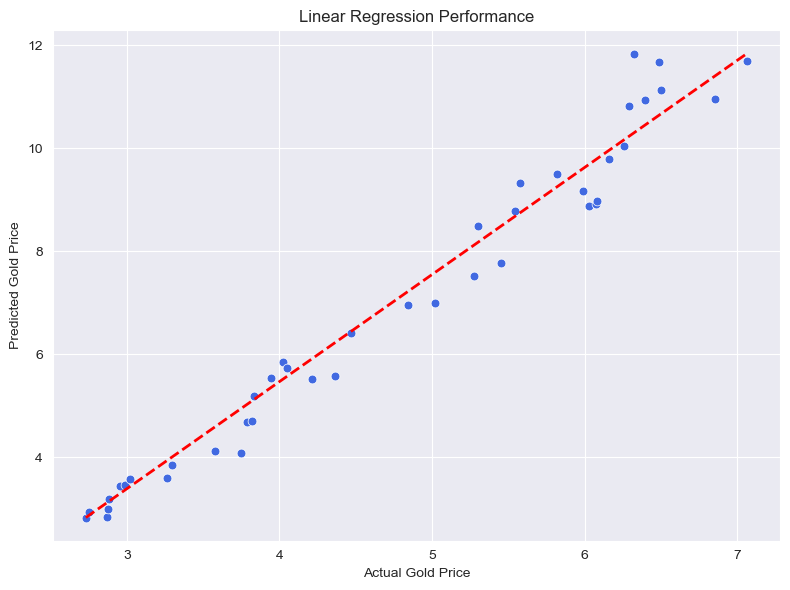

In [8]:
sns.set_style('darkgrid')

save_path = "../outputs/figures/pred_scatter.png"
os.makedirs(os.path.dirname(save_path), exist_ok=True)

y_test_real = np.exp(y_test)       
y_pred_real = np.exp(y_pred)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_real, y=y_pred_real, color='royalblue', s=40)

plt.plot([y_test_real.min(), y_test_real.max()],
         [y_pred_real.min(), y_pred_real.max()],
         color='red', linestyle='--', linewidth=2, label='Ideal Fit (y=x)')

plt.xlabel('Actual Gold Price')
plt.ylabel('Predicted Gold Price')
plt.title('Linear Regression Performance')
plt.tight_layout()
plt.savefig(save_path)
plt.show()


In [24]:
y_pred_series = pd.Series(y_pred_real, index=y_test_real.index, name='Predicted')


df = pd.DataFrame({
    'Actual': y_test_real,
    'Predicted': y_pred_series,
    'Residual': y_test_real - y_pred_series
})

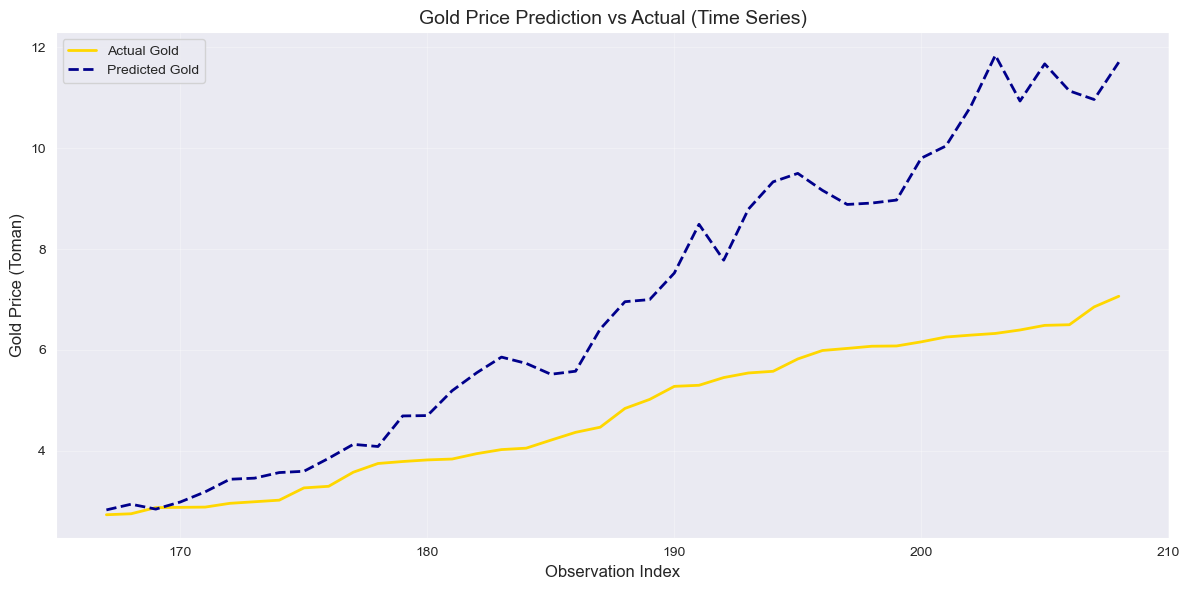

In [19]:
plt.figure(figsize=(12,6))
plt.plot(df.index, df['Actual'], label='Actual Gold', color='gold', linewidth=2)
plt.plot(df.index, df['Predicted'], label='Predicted Gold', color='darkblue', linestyle='--', linewidth=2)
plt.title('Gold Price Prediction vs Actual (Time Series)', fontsize=14)
plt.xlabel('Observation Index', fontsize=12)
plt.ylabel('Gold Price (Toman)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("../outputs/figures/pred_line.png")
plt.show()


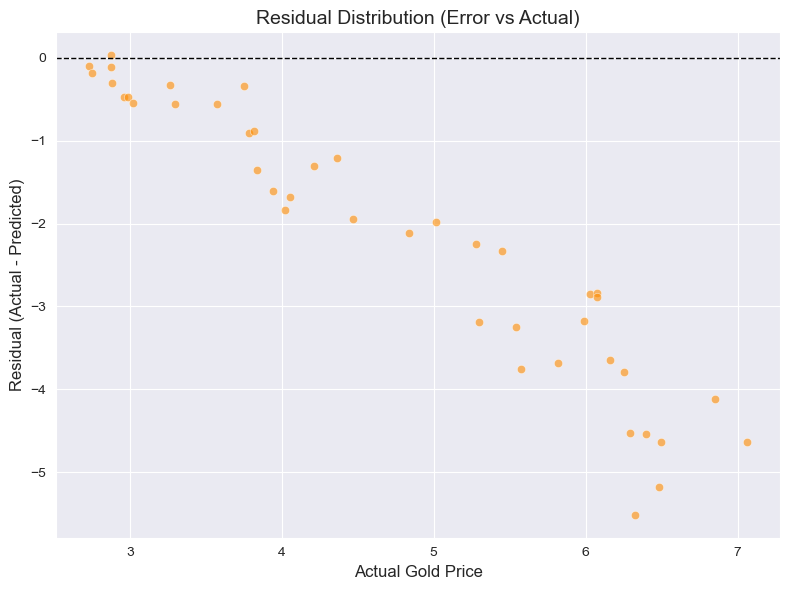

In [26]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test_real, y=df['Residual'], color='darkorange', alpha=0.6)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title('Residual Distribution (Error vs Actual)', fontsize=14)
plt.xlabel('Actual Gold Price', fontsize=12)
plt.ylabel('Residual (Actual - Predicted)', fontsize=12)
plt.tight_layout()
plt.savefig('../outputs/figures/residual_scatter.png')
plt.show()


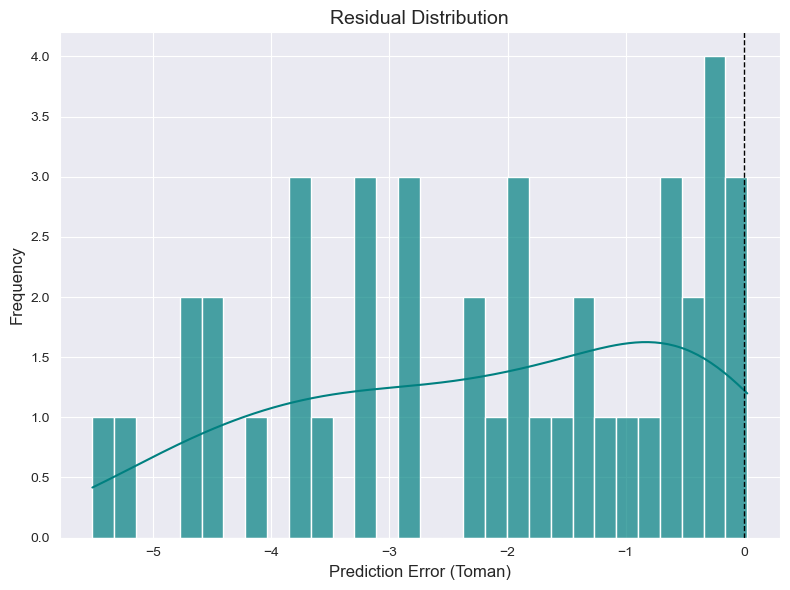

In [28]:
plt.figure(figsize=(8,6))
sns.histplot(df['Residual'], bins=30, kde=True, color='teal', alpha=0.7)
plt.title('Residual Distribution', fontsize=14)
plt.xlabel('Prediction Error (Toman)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.tight_layout()
plt.savefig('../outputs/figures/residual_distribution.png')
plt.show()
